In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
import pickle
import time
import matplotlib.pyplot as plt

In [2]:
def initializeWeights(n_in, n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
       
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""

    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W

In [3]:
def sigmoid(z):
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""
    sigmoidresult = 1.0 / (1.0 + np.exp(-z))

    return sigmoidresult

In [4]:
def preprocess():
    """ Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set

     Some suggestions for preprocessing step:
     - feature selection"""

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    # Split the training sets into two sets of 50000 randomly sampled training examples and 10000 validation examples. 

    # ------------Initializing preprocess arrays-------------#
    train_preprocess = np.zeros(shape=(50000, 784))
    train_data = np.zeros(shape=(50000, 784))
    validation_preprocess = np.zeros(shape=(10000, 784))
    test_preprocess = np.zeros(shape=(10000, 784))
    train_label_preprocess = np.zeros(shape=(50000,))
    validation_label_preprocess = np.zeros(shape=(10000,))
    test_label_preprocess = np.zeros(shape=(10000,))

    # ------------Initializing counter variables----------------#
    train_len = 0
    validation_len = 0
    test_len = 0
    train_label_len = 0
    validation_label_len = 0
    
    # ------------Splitting the data set into 6 arrays-----------#
    for key in mat:
        # When the set is training set
        if "train" in key:
            label = key[-1]  # get the corresponding label
            digit_matrices = mat.get(key)
            per_digit_train_set_range = range(digit_matrices.shape[0])
            digit_matrices_perm = np.random.permutation(per_digit_train_set_range)
            digit_matrices_len = len(digit_matrices)  # get the length of current training set
            tag_len = digit_matrices_len - 1000  # defines the number of examples which will be added into the training set

            # Adding data to training set
            train_preprocess[train_len:train_len + tag_len] = digit_matrices[digit_matrices_perm[1000:], :]
            train_len += tag_len

            train_label_preprocess[train_label_len:train_label_len + tag_len] = label
            train_label_len += tag_len

            # Adding data to validation set
            validation_preprocess[validation_len:validation_len + 1000] = digit_matrices[digit_matrices_perm[0:1000], :]
            validation_len += 1000

            validation_label_preprocess[validation_label_len:validation_label_len + 1000] = label
            validation_label_len += 1000

        # When set is to test set
        elif "test" in key:
            label = key[-1]
            digit_matrices = mat.get(key)
            per_digit_test_set_range = range(digit_matrices.shape[0])
            digit_matrices_perm = np.random.permutation(per_digit_test_set_range)
            digit_matrices_len = len(digit_matrices)
            
            test_label_preprocess[test_len:test_len + digit_matrices_len] = label
            test_preprocess[test_len:test_len + digit_matrices_len] = digit_matrices[digit_matrices_perm]
            test_len += digit_matrices_len
            
    # Shuffle,double and normalize
    train_size = range(train_preprocess.shape[0])
    train_perm = np.random.permutation(train_size)
    train_data = train_preprocess[train_perm]
    train_data = np.double(train_data)
    train_data = train_data / 255.0
    train_label = train_label_preprocess[train_perm]
    
    validation_size = range(validation_preprocess.shape[0])
    vali_perm = np.random.permutation(validation_size)
    validation_data = validation_preprocess[vali_perm]
    validation_data = np.double(validation_data)
    validation_data = validation_data / 255.0
    validation_label = validation_label_preprocess[vali_perm]

    test_size = range(test_preprocess.shape[0])
    test_perm = np.random.permutation(test_size)
    test_data = test_preprocess[test_perm]
    test_data = np.double(test_data)
    test_data = test_data / 255.0
    test_label = test_label_preprocess[test_perm]
    
    # Feature selection

    features_to_delete = []
    features_to_select = []
    Number_of_Features = np.shape(validation_data)[1]

    # Ignore features that are not of importance to us.  
    
    for i in range(Number_of_Features):
        # if feature is not important in training data, validation data & testing datay
        if np.ptp(train_data[:,i]) == 0:
            if np.ptp(validation_data[:,i]) == 0:
                if np.ptp(test_data[:,i]) == 0:
                    features_to_delete.append(i)

    for i in range(Number_of_Features):
        if (i not in features_to_delete):
            features_to_select.append(i);
            
    # to report the selected features 
    # print (features_to_select)
    selected_features = np.array(features_to_select)
    
    # delete the respective column of features
    train_data = np.delete(train_data, features_to_delete, axis=1)
    validation_data = np.delete(validation_data, features_to_delete, axis=1)
    test_data = np.delete(test_data, features_to_delete, axis=1)
    
    print('preprocess done')

    return train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features

In [5]:
def nnObjFunction(params, *args):
    """% nnObjFunction computes the value of objective function (negative log 
    %   likelihood error function with regularization) given the parameters 
    %   of Neural Networks, thetraining data, their corresponding training 
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.
       
    % Output: 
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input 
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden 
    %     layer to unit i in output layer."""

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    obj_val = 0

    # Your code here
    
    label = np.array(training_label);
    rows = label.shape[0];
    rowsIndex = np.array([i for i in range(rows)])
    training_label = np.zeros((rows,10))
    # Set the kth column in "training_label" to 1 for label k
    training_label[rowsIndex,label.astype(int)]=1

    # Adding bias to training data and feed forwarding
    BiasTerm = np.ones(training_data.shape[0])
    training_data = np.column_stack((training_data,BiasTerm))
    num_samples = training_data.shape[0]
    
    # Finding the hidden output using sigmoid
    HiddenOutput = sigmoid(np.dot(training_data,w1.T))
    
    # Adding bias term to hidden layer
    NewBias = np.ones(HiddenOutput.shape[0])
    HiddenOutputWithBias = np.column_stack((HiddenOutput, NewBias))

    # Finding the final output using sigmoid
    FinalOutput = sigmoid(np.dot(HiddenOutputWithBias,w2.T))
    
    # Calculating error to find the Gradient using formula given in handout
    Delta = FinalOutput - training_label
    
    # Using the formula shared in handout. 
    Gradient_w2 = np.dot(Delta.T,HiddenOutputWithBias)
    Gradient_w1 = np.dot(((1-HiddenOutputWithBias)*HiddenOutputWithBias* (np.dot(Delta,w2))).T,training_data)
    
    # Updating gradient w1 to remove bias hidden nodes
    Gradient_w1 = np.delete(Gradient_w1, n_hidden,0)
    
    # Calculating NLL error function and gradient of error function
    lnFinal = np.log(FinalOutput)
    lnOneFinal  = np.log(1-FinalOutput)
    part_1 = (np.sum(-1*(training_label*lnFinal+(1 - training_label)*lnOneFinal)))
    part_1 = part_1/num_samples
    
    # Adding Regularization 
    sw1 = np.sum(np.square(w1))
    sw2 = np.sum(np.square(w2))
    part_2 = (lambdaval/(2*num_samples))* (sw1 +  sw2)
    
    # Final formula
    obj_val = part_1 + part_2

    # Regularization will not impact for lambdaval 0, for others it will
    Gradient_w1 = Gradient_w1 + lambdaval * w1
    Gradient_w2 = Gradient_w2 + lambdaval * w2  

    # Make sure you reshape the gradient matrices to a 1D array. for instance if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    # obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    obj_grad = np.array([])
    obj_grad = np.concatenate((Gradient_w1.flatten(), Gradient_w2.flatten()),0)
    obj_grad = obj_grad/num_samples
    
    return (obj_val, obj_grad)

In [6]:
def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature 
    %       vector of a particular image
       
    % Output: 
    % label: a column vector of predicted labels"""
 
    Num_of_Items=data.shape[0]    

    # Adding bias term
    Bias = np.zeros([len(data), 1])
    DataWithBias = np.append(data, Bias ,1)
    
    hidden_input = np.dot(DataWithBias ,w1.T)
    hidden_output = sigmoid(hidden_input)
    
    # Second layer - Adding Bias Term   
    Bias = np.zeros([len(hidden_output), 1])
    FinalDataWithBias = np.append(hidden_output, Bias, 1)
    final_input = np.dot(FinalDataWithBias, w2.T)
    final_output = sigmoid(final_input)

    #Initialize an dummy output array
    label_list = [-1]*Num_of_Items
    for i in range(Num_of_Items):
        label_list[i] = np.argmax(final_output[i]);
    labels = np.array(label_list)

    return labels

preprocess done


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Metrics with hidden layer=4,lambda=0
Time used: 46.856728


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:79: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Metrics with hidden layer=4,lambda=5
Time used: 48.588778
Metrics with hidden layer=4,lambda=10
Time used: 47.408978000000005
Metrics with hidden layer=4,lambda=15
Time used: 47.72220800000002
Metrics with hidden layer=4,lambda=20
Time used: 47.773420999999985
Metrics with hidden layer=4,lambda=25
Time used: 45.97816999999998
Metrics with hidden layer=4,lambda=30
Time used: 45.836378999999965
Metrics with hidden layer=4,lambda=35
Time used: 45.84388999999999
Metrics with hidden layer=4,lambda=40
Time used: 45.32818400000002
Metrics with hidden layer=4,lambda=45
Time used: 45.03710099999995
Metrics with hidden layer=4,lambda=50
Time used: 44.714913000000024
Metrics with hidden layer=4,lambda=55
Time used: 46.29141100000004
Metrics with hidden layer=8,lambda=0
Time used: 53.50587800000005
Metrics with hidden layer=8,lambda=5
Time used: 50.45010300000001
Metrics with hidden layer=8,lambda=10
Time used: 50.107812999999965
Metrics with hidden layer=8,lambda=15
Time used: 51.68030799999997
M

NameError: name 'hiddenlayerstart' is not defined

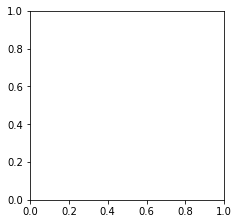

In [7]:
"""**************Neural Network Script Starts here********************************"""
########## Train Neural Network with λ from 0 to 60 and units of hidden layer from 4,8,12,16,20,24,28,32 ##########

train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features = preprocess()

#  Train Neural Network

# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]

# set the number of nodes in hidden unit (not including bias unit)
n_hidden = 50

# set the number of nodes in output unit
n_class = 10

# try different regularization hyper-parameters
lambdastart=0
lambdaend=60
increment=5
lambdaIterate=int((lambdaend-lambdastart)/increment)

# try different units of the hidden layers 
hiddenOption=[4,8,12,16,20,24,28,32]
lenhiddenOption=int(len(hiddenOption))

i = 0

#create multiple empty matrix to store the accuracy of training, validate and test accuracy
TrainingAccuracy = np.zeros((lambdaIterate,lenhiddenOption))
ValidationAccuracy = np.zeros((lambdaIterate,lenhiddenOption))
TestAccuracy=np.zeros((lambdaIterate,lenhiddenOption))
lambdavals=np.zeros((lambdaIterate,lenhiddenOption))

# loop for different hidden layer units
for indexHiddenlayer in np.arange(0,lenhiddenOption):
    i = 0
    n_hidden=hiddenOption[indexHiddenlayer]
    
    # initialize the weights into some random matrices; from the professor
    initial_w1 = initializeWeights(n_input, n_hidden);
    initial_w2 = initializeWeights(n_hidden, n_class);

    # unroll 2 weight matrices into single column vector; from the professor
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()),0)

    #loop for different λ; start our own loop
    for lambdaval in np.arange(lambdastart,lambdaend,increment):
        #start record time
        start = time.clock()
        
        lambdavals[i]=lambdaval
    
        args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

        #Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example

        opts = {'maxiter' : 50}    # Preferred value.

        nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args,method='CG', options=opts)
        params=nn_params.x
        
        #Reshape nnParams from 1D vector into w1 and w2 matrices
        w1 = params[0:n_hidden * (n_input + 1)].reshape( (n_hidden, (n_input + 1)))
        w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
        
        
        #store accuracy of the computed parameters
        Trainingpredicted_label = nnPredict(w1,w2,train_data)
        TrainingAccuracy[i][indexHiddenlayer] = 100*np.mean((Trainingpredicted_label == train_label).astype(float))
        
        Validationpredicted_label = nnPredict(w1,w2,validation_data)
        ValidationAccuracy[i][indexHiddenlayer] = 100*np.mean((Validationpredicted_label == validation_label).astype(float))
        
        Testpredicted_label = nnPredict(w1,w2,test_data)
        TestAccuracy[i][indexHiddenlayer] = 100*np.mean((Testpredicted_label == test_label).astype(float))

        print('Metrics with hidden layer='+str(n_hidden)+',lambda='+str(lambdaval))
        elapsed = (time.clock() - start)
        print("Time used:",elapsed)

        i=i+1

        


[[28.284 83.512 88.75  91.306 92.178 92.586 93.034 93.204]
 [30.158 83.466 88.996 91.632 92.174 92.268 93.154 93.078]
 [31.312 83.062 88.452 91.372 92.108 92.578 93.552 93.314]
 [32.406 83.46  88.596 91.36  92.338 92.362 93.482 93.18 ]
 [34.98  82.914 88.548 91.21  92.118 92.452 93.106 93.104]
 [36.142 83.87  88.804 91.42  92.012 92.456 93.248 92.856]
 [34.416 83.54  88.844 91.208 91.908 91.518 93.06  92.982]
 [33.864 83.144 88.76  91.146 91.846 91.526 93.012 92.754]
 [34.162 83.804 88.898 91.2   91.6   91.71  92.914 92.468]
 [31.232 83.922 88.442 91.168 91.576 91.586 92.842 92.444]
 [33.726 84.29  88.518 91.24  91.49  91.546 92.708 92.116]
 [37.264 82.87  88.572 91.086 91.638 91.274 92.654 92.302]]
[[27.44 82.42 87.74 90.54 91.18 91.48 92.33 92.37]
 [29.06 82.52 88.1  90.88 91.2  91.35 92.13 92.07]
 [30.21 81.96 87.47 90.57 91.13 91.59 92.53 92.37]
 [31.18 82.35 87.51 90.47 91.57 91.6  92.56 92.22]
 [33.71 81.79 87.47 90.38 91.26 91.73 92.1  92.15]
 [35.03 82.68 87.74 90.53 91.04 91.6

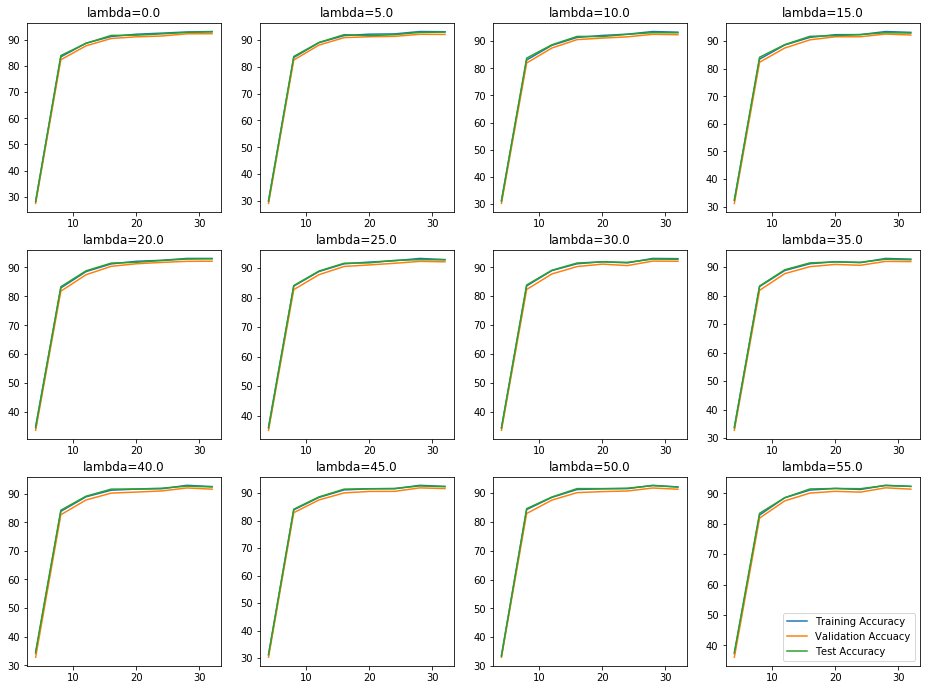

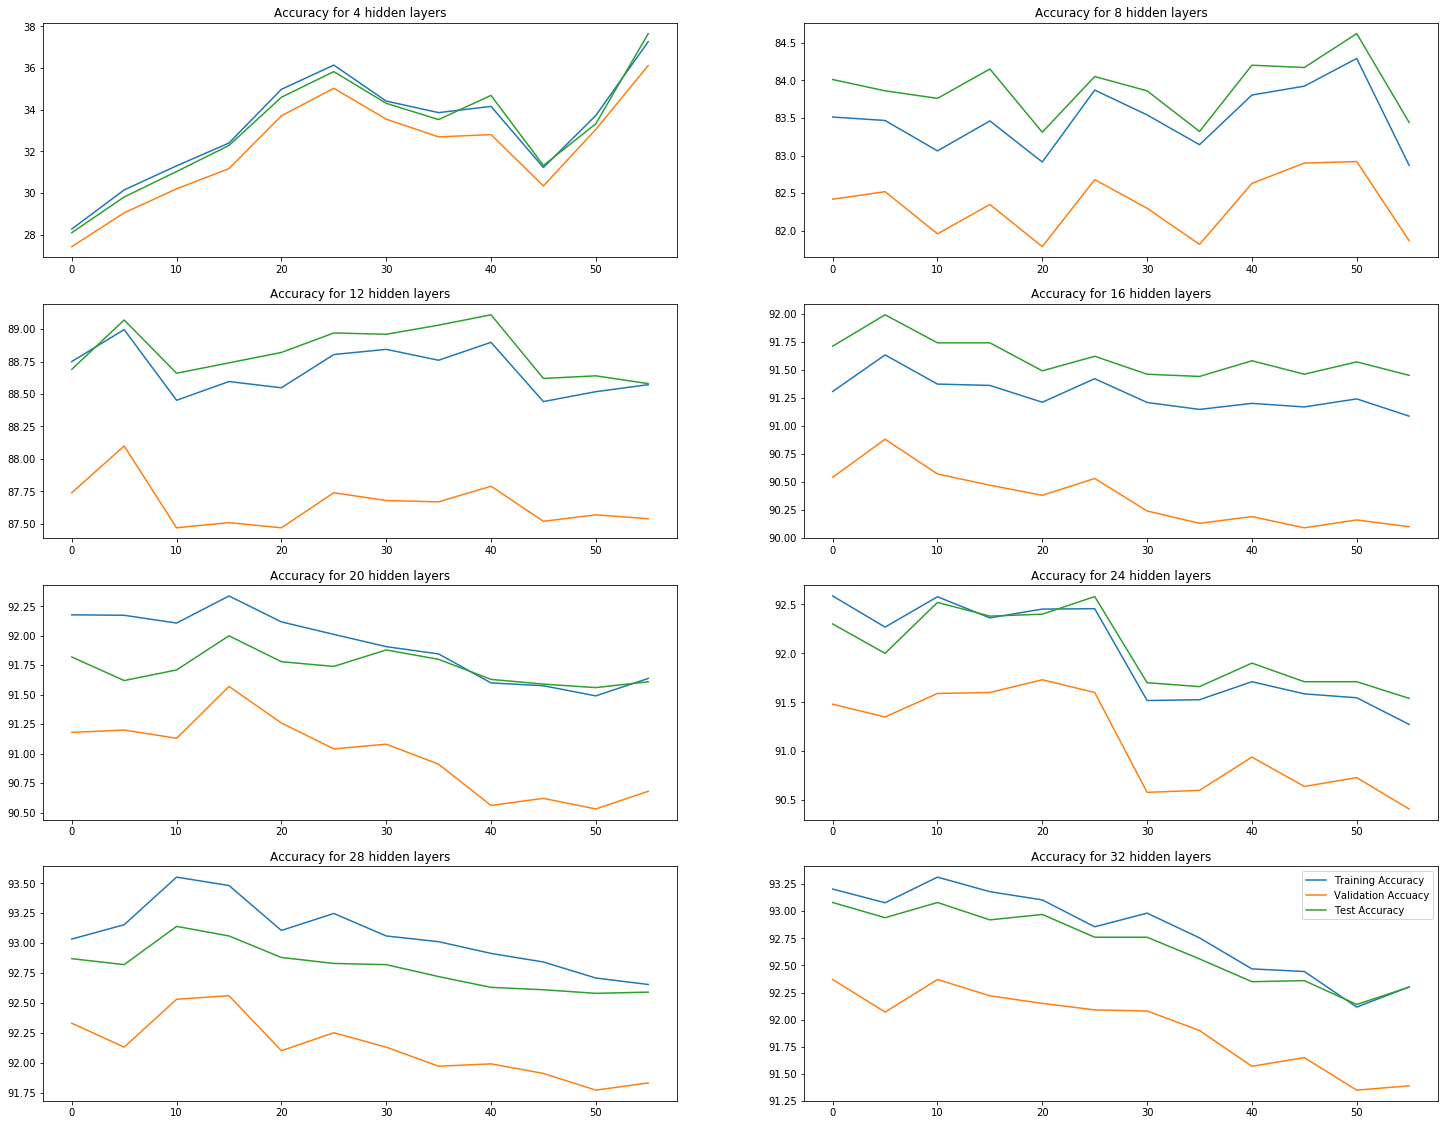

In [21]:
# print out accuracy of NN with different λ (lambda). (x: hidden layer unites, y: accuracy)
lambdavalsOne=lambdavals[:,0]
lenlambdavals=lambdavals.shape[0]
plotRow=int(lenlambdavals/4)+1
fig = plt.figure(figsize=[16,16])
for indexlambdavals in np.arange(0,lenlambdavals,1):
    plt.subplot(plotRow, 4, indexlambdavals+1)
    plt.plot(hiddenOption,TrainingAccuracy[indexlambdavals,:])
    plt.plot(hiddenOption,ValidationAccuacy[indexlambdavals,:])
    plt.plot(hiddenOption,TestAccuracy[indexlambdavals,:])
    plt.title('lambda='+str(lambdavalsOne[indexlambdavals]))
plt.legend(['Training Accuracy','Validation Accuacy','Test Accuracy'])


#print out accuracy of NN with different hidden layer unites. (x: λ (lambda), y: accuracy)
plotRow=int(lenhiddenOption/2)+1
fig = plt.figure(figsize=[25,25])
for indexHiddenlayer in np.arange(0,lenhiddenOption,1):
    plt.subplot(plotRow, 2, indexHiddenlayer+1)
    plt.plot(lambdavals[:,0],TrainingAccuracy[:,indexHiddenlayer])
    plt.plot(lambdavals[:,0],ValidationAccuacy[:,indexHiddenlayer])
    plt.plot(lambdavals[:,0],TestAccuracy[:,indexHiddenlayer])
    plt.title('Accuracy for '+str(hiddenOption[indexHiddenlayer])+' hidden layers')

plt.legend(['Training Accuracy','Validation Accuacy','Test Accuracy'])

print(TrainingAccuracy)
print(ValidationAccuacy)
print(TestAccuracy)


In [18]:
######################### Train Neural Network with optimal λ and hidden layer unites ##################

# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]; 

# set optimal number of nodes in hidden unit (not including bias unit)
n_hidden = 28;  ##???? 

# set the number of nodes in output unit
n_class = 10;

# initialize the weights into some random matrices
initial_w1 = initializeWeights(n_input, n_hidden);
initial_w2 = initializeWeights(n_hidden, n_class);

# unroll 2 weight matrices into single column vector
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()),0)

# set optimal regularization hyper-parameter
lambdaval = 15;    ##????

args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

#Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example

opts = {'maxiter' : 50}    # Preferred value.

nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args,method='CG', options=opts)

params = nn_params.get('x')

#Reshape nnParams from 1D vector into w1 and w2 matrices
w1 = params[0:n_hidden * (n_input + 1)].reshape( (n_hidden, (n_input + 1)))
w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))


#Test the computed parameters

predicted_label = nnPredict(w1,w2,train_data)

#find the accuracy on Training Dataset

print ('\n Training set Accuracy:' + str(100*np.mean((predicted_label == train_label).astype(float))) + '%')

predicted_label = nnPredict(w1,w2,validation_data)

#find the accuracy on Validation Dataset

print ('\n Validation set Accuracy:' + str(100*np.mean((predicted_label == validation_label).astype(float))) + '%')


predicted_label = nnPredict(w1,w2,test_data)

#find the accuracy on Validation Dataset

print ('\n Test set Accuracy:' + str(100*np.mean((predicted_label == test_label).astype(float))) + '%')


####################################### export parameters to a pickle file ###################################
import pickle
feature=[1,2,3,4,5,6]
feature2=[[1,2],[2,3]]
favorite_color = { "selectedfeatures": selected_features, 
                  "optimal hidden layer units": n_hidden,
                 "optimal lambda":lambdaval,
                 "w1":w1,
                 "w2":w2}
 
pickle.dump( favorite_color, open( "params.pickle", "wb" ) )


 Training set Accuracy:93.22399999999999%

 Validation set Accuracy:92.39%

 Test set Accuracy:93.05%
